<a href="https://colab.research.google.com/github/jainoos007/CNN-Based-Pet-Image-Classification/blob/main/Cat_vs_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import collections

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()  # Upload the `kaggle.json` file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohammedjainoos","key":"971a415f7659fa59dce799c383ecdf19"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Step 1: Load Dataset

# Download the dataset
!kaggle datasets download -d arpitjain007/dog-vs-cat-fastai
# Unzip the dataset
!unzip -q dog-vs-cat-fastai.zip -d dataset

data_dir = "dataset/dogscats"
train_dir = os.path.join(data_dir, "train")
validation_dir = os.path.join(data_dir, "valid")

Dataset URL: https://www.kaggle.com/datasets/arpitjain007/dog-vs-cat-fastai
License(s): unknown


In [ ]:
# Step 2: Data Preprocessing with ImageDataGenerator
img_size = (150, 150)
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# **Fixed: Make sure train_generator and val_generator are properly assigned**
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
# Step 3: Build the CNN Model with Global Average Pooling
model = tf.keras.Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.GlobalAveragePooling2D(),  # Better than Flatten() for generalization
    tf.keras.layers.Dropout(0.5),  # Regularization to prevent overfitting
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary Classification
])


In [ ]:
# Step 4: Compile Model with Learning Rate Scheduling
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping for better training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# **Fixed: Train the Model (Ensure train_generator is correctly assigned)**
epochs = 20
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[early_stopping])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 163s 217ms/step - accuracy: 0.5430 - loss: 0.6837 - val_accuracy: 0.6235 - val_loss: 0.6332
Epoch 2/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 148s 206ms/step - accuracy: 0.6309 - loss: 0.6398 - val_accuracy: 0.6680 - val_loss: 0.5907
Epoch 3/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 148s 206ms/step - accuracy: 0.6849 - loss: 0.5998 - val_accuracy: 0.7035 - val_loss: 0.5634
Epoch 4/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 153s 213ms/step - accuracy: 0.7020 - loss: 0.5700 - val_accuracy: 0.7450 - val_loss: 0.5326
Epoch 5/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 149s 208ms/step - accuracy: 0.7295 - loss: 0.5415 - val_accuracy: 0.7730 - val_loss: 0.4845
Epoch 6/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 151s 210ms/step - accuracy: 0.7530 - loss: 0.5118 - val_accuracy: 0.7985 - val_loss: 0.4499
Epoch 7/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 149s 208ms/step - accuracy: 0.7866 - loss: 0.4605 - val_accuracy: 0.7890 - val_loss: 0.4518
Epoch 8/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 150s 208ms/step - accuracy: 0.8062 -

In [ ]:
# Step 6: Test Prediction Function
def predict_image(image_path, threshold=0.5):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)[0][0]
    class_name = "Dog" if prediction > threshold else "Cat"

    plt.imshow(img)
    plt.title(f"Prediction: {class_name} ({prediction:.2f})")
    plt.axis("off")
    plt.show()

# Save Model
model.save("cat_dog_classifier.keras")
print("Model saved successfully!")


Model saved successfully!


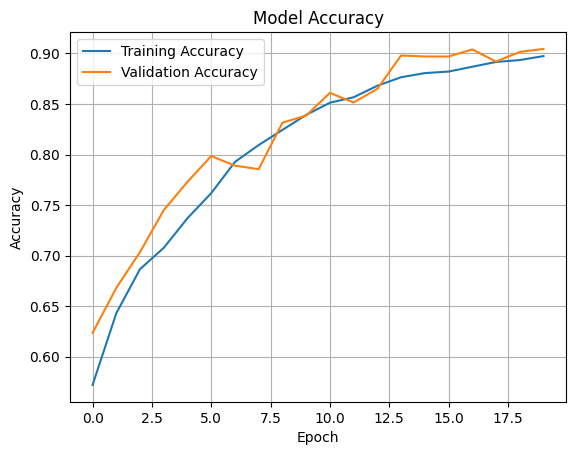

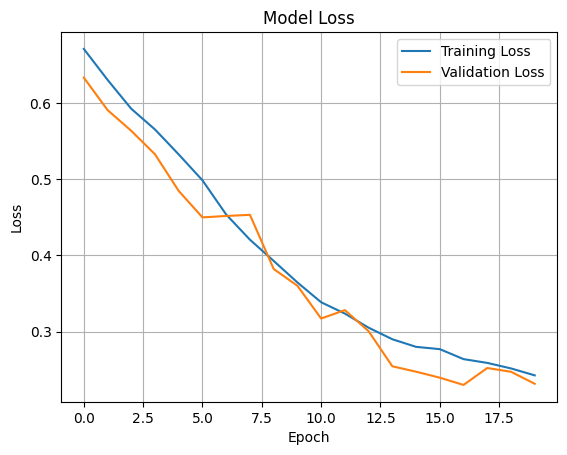

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


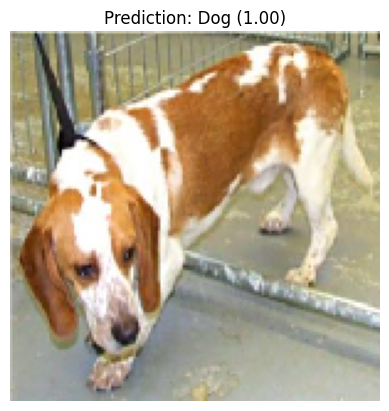

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


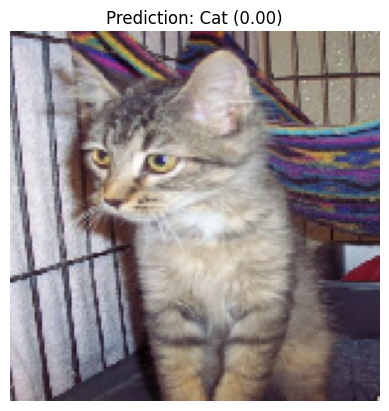

In [ ]:
predict_image("132.jpg")
predict_image("2.jpg")
